In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/zz1994/packages/ABCMB')

In [3]:
import jax.numpy as jnp
import numpy as np
from jax import jit, vmap, lax, grad, config, jacfwd
import equinox as eqx
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time
from classy import Class
import diffrax

#import ABCMB
from ABCMB import main, cosmology
from ABCMB import constants as cnst
from ABCMB.hyrex import hyrex

# Inputs

To create and call methods from a background objects, we at least need a list of model specific fluids, and the cosmological parameters of the current computation.

Here is a run with LCDM+massive Nu's, assuming standard cosmological parameters.

In [29]:
#model = main.Model(ellmin=2, ellmax=2500, lensing=False, has_MasslessNeutrinos=True, has_MassiveNeutrinos=False)
model = main.Model(ellmin=2, ellmax=2500, lensing=False, has_MasslessNeutrinos=True, has_MassiveNeutrinos=False)

In [30]:
params = {
    'h': 0.6762,
    'omega_cdm': 0.1193,
    'omega_b': 0.0225,
    'A_s': 2.12424e-9,
    'n_s': 0.9709,
    'Neff': 3.044,
    'YHe': 0.245,
    'TCMB0': 2.34865418e-4,
    'T_nu': (4. / 11.)**(1. / 3.) * 2.34865418e-4,
    'N_ncdm': 0,
    'T_ncdm': 0.71611 * 2.34865418e-4,
    'm_ncdm': 0.06,
}
z_reion = 11
Delta_z_reion = 0.5

Now jit over a function that creates a BG module

In [31]:
def f1(params):
    params = model.add_derived_parameters(params)
    BG = cosmology.Background(params, model.species_list, model.RM)
    return BG

In [32]:
j1 = eqx.filter_jit(f1)

In [33]:
for i in range(3):
    s = time.time()
    BG = j1(params)
    BG.tau_tab.block_until_ready()
    print(time.time() - s)

/ext3/miniconda3/lib/python3.10/site-packages/equinox/_jit.py:55: UserWarning: `diffrax.diffeqsolve(..., discrete_terminating_event=...)` is deprecated in favour of the more general `diffrax.diffeqsolve(..., event=...)` interface. This will be removed in some future version of Diffrax.
  out = fun(*args, **kwargs)
/ext3/miniconda3/lib/python3.10/site-packages/equinox/_jit.py:55: UserWarning: `diffrax.diffeqsolve(..., discrete_terminating_event=...)` is deprecated in favour of the more general `diffrax.diffeqsolve(..., event=...)` interface. This will be removed in some future version of Diffrax.
  out = fun(*args, **kwargs)


36.21988010406494
0.2558107376098633
0.2537550926208496


In [ ]:
lna = jnp.linspace(-10., 0., 2000)
plt.plot(lna, BG.xe(lna))
plt.show()

# Comparison to HYREC

In [10]:
hyrec_full = np.loadtxt("/home/zz1994/packages/HYREC-2/ABCMB_test_FULL.dat")
hyrec_swift = np.loadtxt("/home/zz1994/packages/HYREC-2/ABCMB_test_SWIFT.dat")

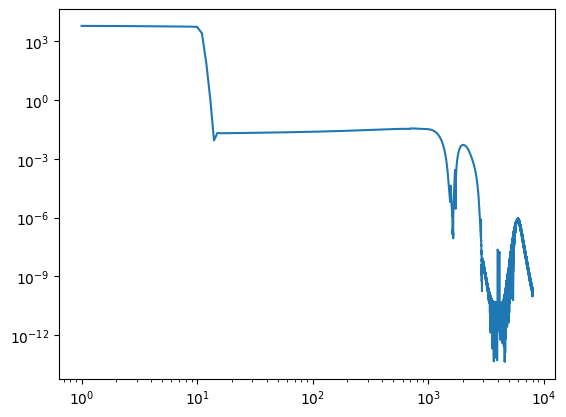

In [31]:
hyrec = hyrec_full
z_hyrec = hyrec[:, 0]
xe_hyrec = hyrec[:, 1]
Tm_hyrec = hyrec[:, 2]*cnst.kB
lna = -jnp.log(1.+z_hyrec)
xe_ABCMB = BG.xe(lna)

#plt.plot(z_hyrec, abs(xe_ABCMB-xe_hyrec)/xe_hyrec)
plt.plot(z_hyrec, abs(xe_ABCMB-xe_hyrec)/xe_hyrec)
#plt.xlim((-9, -5))
#plt.ylim((1.e-12, 1))
plt.yscale("log")
plt.xscale("log")
plt.show()

# Saving Output

## A CLASS output

In [23]:
class_a = 1./(1.+class_bg["z"])
class_lna = jnp.log(class_a)
class_tau_tab = jnp.interp(BG.lna_tau_tab, class_lna, class_bg['conf. time [Mpc]'])
class_H_tab = jnp.interp(BG.lna_tau_tab, class_lna, class_bg['H [1/Mpc]']*cnst.c_Mpc_over_s)

class_a = jnp.flip(class_rec['scale factor a'])
class_lna = jnp.log(class_a)
class_xe_tab = jnp.flip(class_rec['x_e'])
class_Tm_tab = jnp.flip(class_rec['Tb [K]']*cnst.kB)
class_kappa_tab = jnp.flip(-jnp.log(class_rec['exp(-kappa)']))

In [24]:
arr = np.array(list(BG.params.items()), dtype=object)
np.savetxt("params.txt", arr, fmt="%s")

np.savez(
    "class_background.npz",
    tau_tab=class_tau_tab,
    H_tab=class_H_tab,
    xe_tab=class_xe_tab,
    lna_xe_tab=class_lna,
    Tm_tab=class_Tm_tab,
    lna_Tm_tab=class_lna,
    kappa_tab=class_kappa_tab,
)

# Comparing to CLASS

In [34]:
class_params = {
    "output": "mPk",
    "H0": BG.params["h"]*100,
    "omega_b": BG.params["omega_b"],
    "omega_cdm": BG.params["omega_cdm"],
    "N_ur": BG.params["N_ur"],
    #"N_ur" : 3.044,
    "YHe": BG.params["YHe"],
    "lensing": "no",
    "N_ncdm": 0,
    "reio_parametrization" : "reio_camb",
    "z_reio" : 11,
    "reionization_width" : 0.5,
    "helium_fullreio_redshift" : 3.5,
    "helium_fullreio_width" : 0.5}


class_params = {
    "output": "mPk",
    "H0": BG.params["h"]*100,
    "omega_b": BG.params["omega_b"],
    "omega_cdm": BG.params["omega_cdm"],
    "N_ur": BG.params["N_ur"],
    #"N_ur" : 3.044,
    "YHe": BG.params["YHe"],
    "lensing": "no",
    "N_ncdm": 0,
    "reio_parametrization" : "reio_none"}


class_lcdm = Class()
class_lcdm.set(class_params)
class_lcdm.compute()

In [35]:
class_bg = class_lcdm.get_background()
class_rec = class_lcdm.get_thermodynamics()

In [30]:
BG.xe(-5.)

Array(0.0003013, dtype=float64)

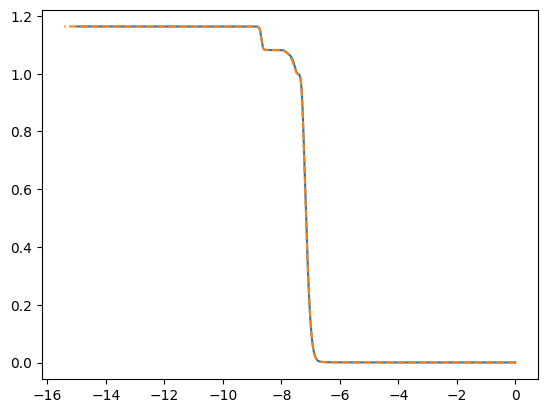

In [36]:
lna = jnp.linspace(-15.0, 0.0, 1000)
plt.plot(lna, BG.xe(lna))
plt.plot(jnp.log(class_rec["scale factor a"]), class_rec["x_e"], "--")
#plt.yscale("log")
plt.show()

### Hubble

In [37]:
a = 1/(1.+class_bg["z"])
H_class = class_bg['H [1/Mpc]'] * cnst.c_Mpc_over_s
H_ABCMB = BG.H(jnp.log(a))

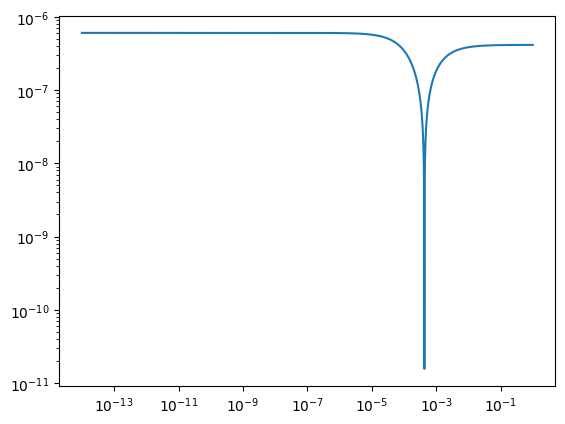

In [38]:
plt.loglog(a, abs(H_class - H_ABCMB)/H_class)
#plt.xlim((1.e-10, 0.))
plt.show()

### Conformal Time

In [36]:
a = 1/(1.+class_bg["z"])
tau_class = class_bg['conf. time [Mpc]']
tau_ABCMB = BG.tau(jnp.log(a))

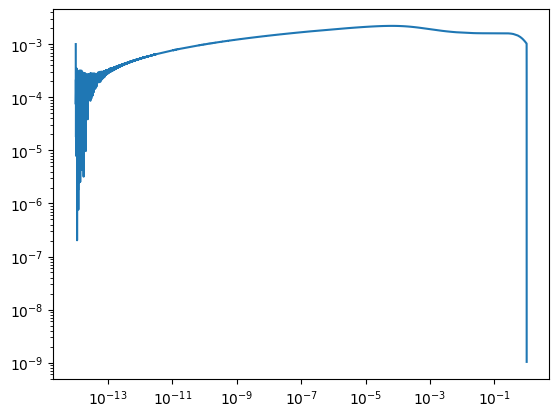

In [37]:
plt.loglog(a, abs(tau_class - tau_ABCMB)/tau_class)
#plt.xlim((1.e-10, 0.))
plt.show()

### xe, Tm

In [39]:
a = 1/(1.+class_rec["z"])
xe_class = class_rec["x_e"]
Tm_class = class_rec['Tb [K]'] * cnst.kB
xe_abcmb = BG.xe(jnp.log(a))
Tm_abcmb = BG.Tm(jnp.log(a))

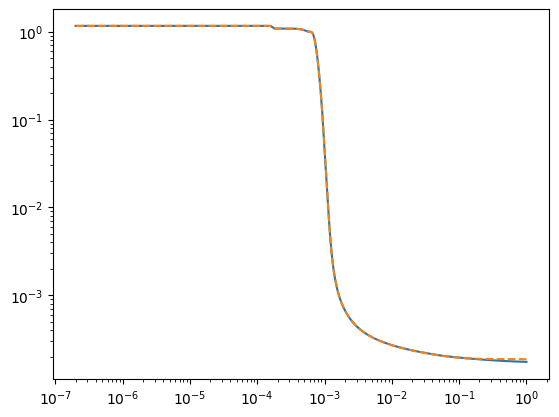

In [40]:
plt.loglog(a, xe_class)
plt.loglog(a, xe_abcmb, "--")
plt.show()

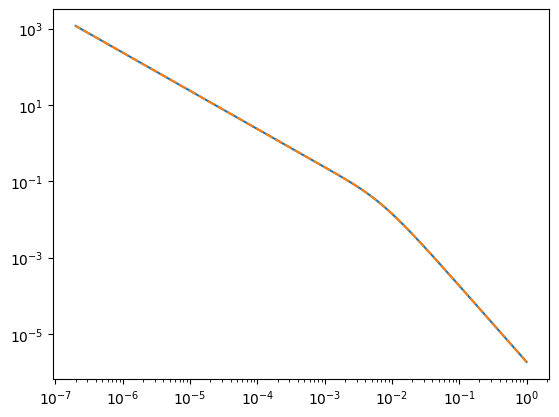

In [41]:
plt.loglog(a, Tm_class)
plt.loglog(a, Tm_abcmb, "--")
plt.show()

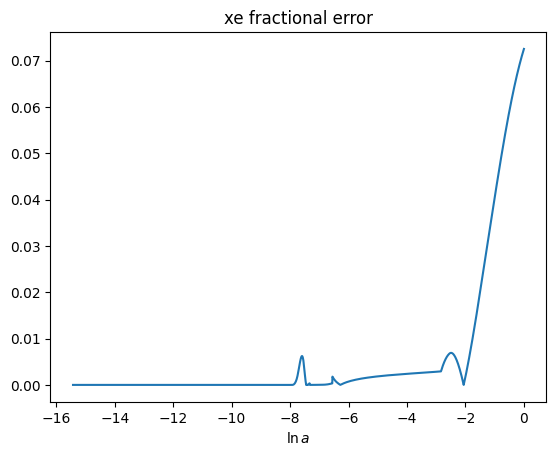

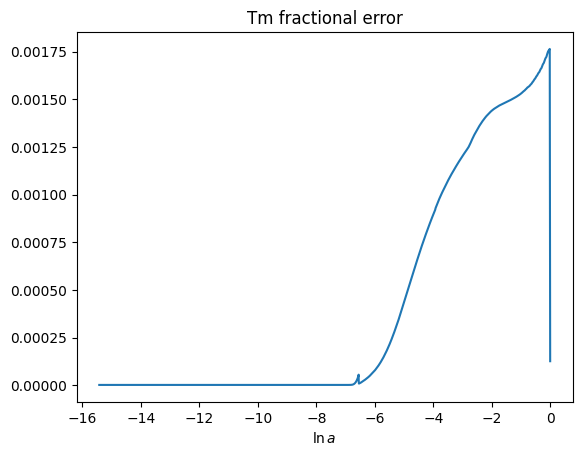

In [42]:
plt.plot(jnp.log(a), abs(xe_abcmb-xe_class)/xe_class)
#plt.yscale("log")
plt.xlabel(r"$\ln{a}$")
plt.title("xe fractional error")
#plt.xlim((-8, -6))
plt.show()

plt.plot(jnp.log(a), abs(Tm_abcmb-Tm_class)/Tm_class)
#plt.yscale("log")
plt.xlabel(r"$\ln{a}$")
#plt.xlim((-8, -6))
plt.title("Tm fractional error")
plt.show()

### Scattering Rate

In [43]:
gammac_class = class_rec["kappa' [Mpc^-1]"]
gammac_abcmb = 1/BG.tau_c(jnp.log(a))

def gammac_abcmb_long(lna):
    a = jnp.exp(lna)
    nH = BG.nH(lna)
    ne = nH * BG.xe(lna)
    return 1./ (1./a/ne/cnst.thomson_xsec/cnst.c*cnst.c_Mpc_over_s)

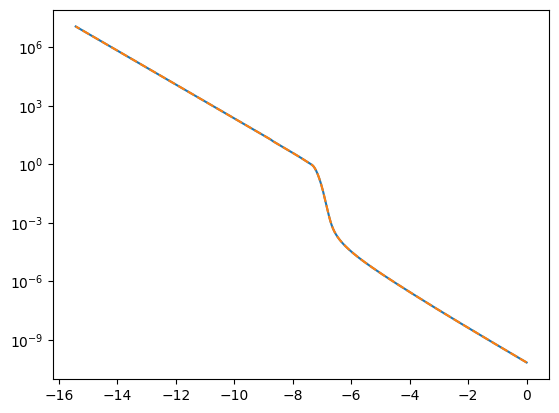

In [44]:
plt.plot(jnp.log(a), gammac_class)
plt.plot(jnp.log(a), gammac_abcmb, "--")
plt.yscale("log")
plt.show()

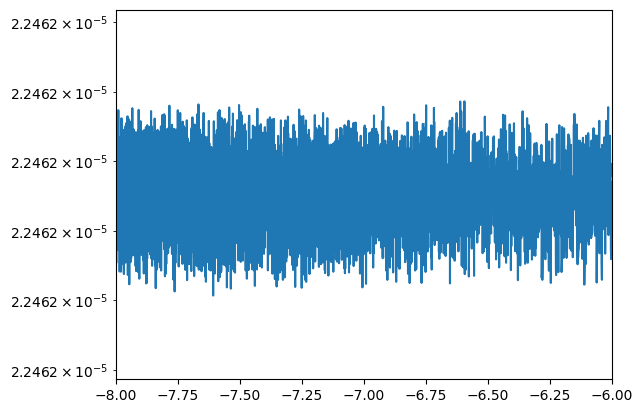

In [45]:
plt.plot(jnp.log(a), abs(gammac_abcmb-gammac_class)/gammac_class)
plt.xlim((-8, -6))
plt.yscale("log")
plt.show()

### Optical depth

In [49]:
expkappa_class = class_rec['exp(-kappa)']
expkappa_abcmb = BG.expmkappa(jnp.log(a))
expkappa_class = -jnp.log(expkappa_class)
expkappa_abcmb = -jnp.log(expkappa_abcmb)

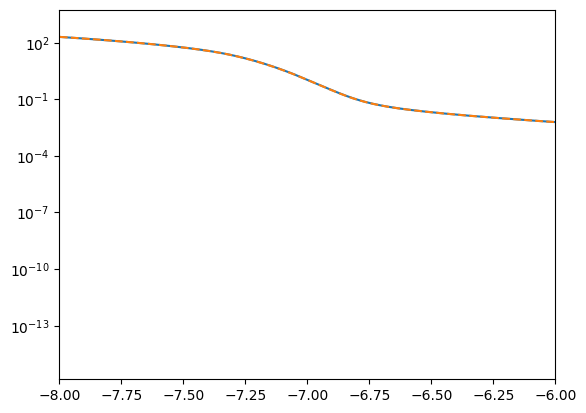

In [50]:
plt.plot(jnp.log(a), expkappa_class)
#plt.plot(jnp.log(a), vmap(solution.evaluate)(jnp.log(a)))
plt.plot(jnp.log(a), expkappa_abcmb, "--")
plt.xlim((-8, -6))
plt.yscale("log")
plt.show()

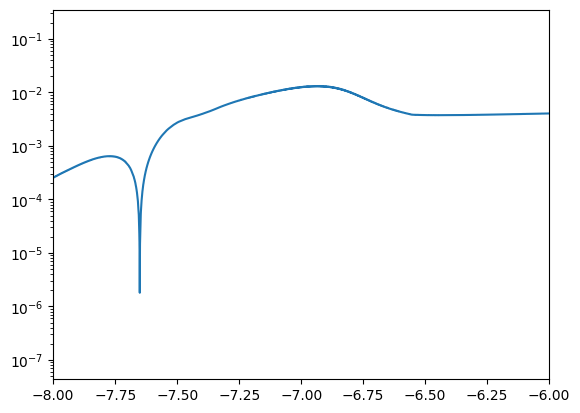

In [53]:
plt.plot(jnp.log(a), abs(expkappa_class-expkappa_abcmb)/expkappa_class)
plt.yscale("log")
plt.xlim((-8, -6))
#plt.ylim((1.e-5, 0.3))
plt.show()

In [59]:
BG.lna_xe_tab.arr.shape

(28333,)

### Visibility

In [58]:
g_class = class_rec['g [Mpc^-1]']
g_abcmb = BG.visibility(jnp.log(a))

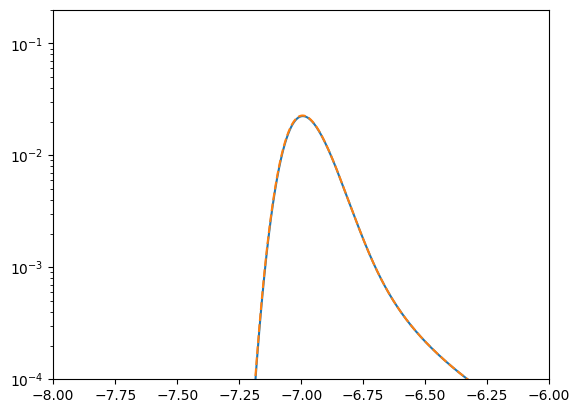

In [68]:
plt.plot(jnp.log(a), g_class)
plt.plot(jnp.log(a), g_abcmb, "--")
plt.xlim((-8, -6))
plt.ylim((1.e-4, 0.2))
plt.yscale("log")
plt.show()

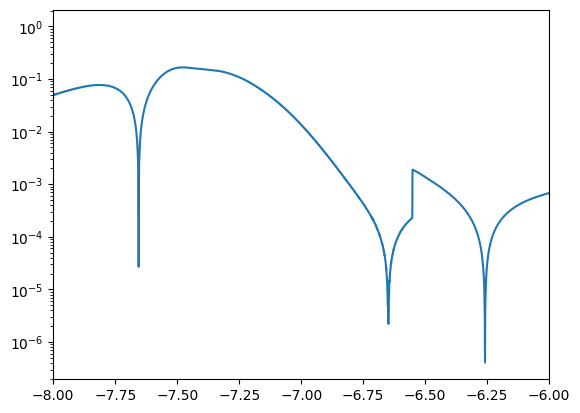

In [56]:
plt.plot(jnp.log(a), abs(g_abcmb-g_class)/g_class)
plt.xlim((-8, -6))
plt.yscale("log")
plt.show()

# Reading Result from CLASS

In [11]:
class_res_dir = "/home/zz1994/packages/class/output/ABCMB_test/noneutrinos00"
bac = np.loadtxt(class_res_dir+"_background.dat")
therm = np.loadtxt(class_res_dir+"_thermodynamics.dat")

In [13]:
bac[:, 4]

array([14248.53227261, 14248.53227261, 14248.53227261, ...,
          95.85369363,    47.79180017,     0.        ], shape=(3000,))

In [16]:
BG = cosmology.ClassBackground()

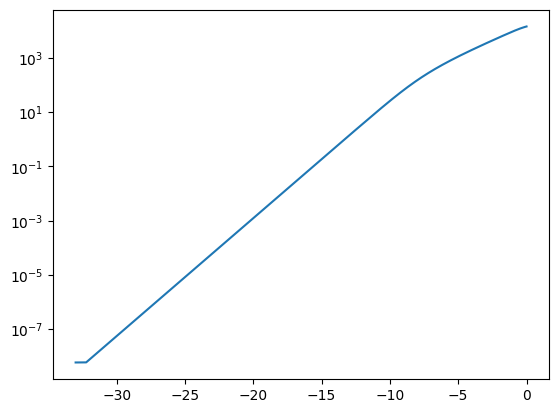

In [20]:
plt.plot(BG.lna_tau_tab, BG.tau_tab)
plt.yscale("log")

In [21]:
BG.params

{np.str_('h'): 0.6762,
 np.str_('omega_cdm'): 0.1193,
 np.str_('omega_b'): 0.0225,
 np.str_('A_s'): 2.12424e-09,
 np.str_('n_s'): 0.9709,
 np.str_('Neff'): 0.0,
 np.str_('YHe'): 0.245,
 np.str_('TCMB0'): 0.000234865418,
 np.str_('T_nu'): 0.00016763891600698252,
 np.str_('N_ncdm'): 0.0,
 np.str_('T_ncdm'): 0.00016818947448398,
 np.str_('m_ncdm'): 0.06,
 np.str_('omega_m'): 0.1418,
 np.str_('R_b'): 0.15867418899858954,
 np.str_('omega_g'): 2.4729742493571234e-05,
 np.str_('H0'): 2.191415436e-18,
 np.str_('N_ur'): 0.0,
 np.str_('omega_nu'): 0.0,
 np.str_('omega_r'): 2.4729742493571234e-05,
 np.str_('R_nu'): 0.0,
 np.str_('omega_Lambda'): 0.3154217102575064}

In [25]:
lna = jnp.log(therm[:, 0])
tau_c_class = 1./therm[:, 4]
tau_c_abcmb = BG.tau_c(lna)

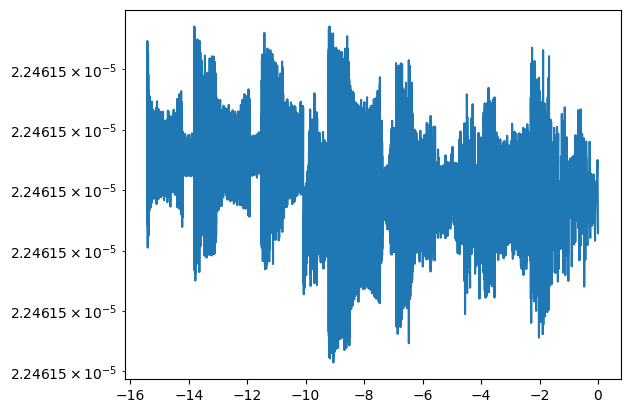

In [26]:
plt.plot(lna, abs(tau_c_class-tau_c_abcmb)/tau_c_class)
plt.yscale("log")
plt.show()

# Solving kappa

TODO: Check in with Hongwan on:

$$
\frac{\kappa_c - \kappa_a}{\kappa_c} \approx 0.005
$$

$$
\frac{e^{-\kappa_c}-e^{-\kappa_a}}{e^{-\kappa_c}} = 1-e^{\kappa_c (0.005)}
$$

$$
g = \frac{\Gamma}{\mathcal{H}} e^{-\kappa}
$$

In [20]:
ath = 1/(class_rec["z"]+1)
class_tauc = lambda lna : 1./jnp.interp(lna, jnp.flip(jnp.log(class_rec['scale factor a'])), jnp.flip(class_rec["kappa' [Mpc^-1]"]))
class_xe = lambda lna : jnp.interp(lna, jnp.flip(jnp.log(class_rec['scale factor a'])), jnp.flip(class_rec["x_e"]))
abg = 1/(class_bg["z"]+1)
class_aH = lambda lna : jnp.exp(lna) * jnp.interp(lna, jnp.log(abg), class_bg['H [1/Mpc]'])

In [21]:
class_int = lambda lna, y, args: -1./class_tauc(lna)/class_aH(lna)
abcmb_int = lambda lna, y, args: -1./BG.tau_c(lna)/BG.aH(lna)

def abcmb_long_int(lna, y, args):
    a = jnp.exp(lna)
    nH = BG.nH(lna)
    ne = nH * class_xe(lna)
    tauc = 1./a/ne/cnst.thomson_xsec/cnst.c*cnst.c_Mpc_over_s
    aH = class_aH(lna)
    return -1./aH/tauc

In [22]:
def compute_optical_depth(integrand):
    term = diffrax.ODETerm(integrand)
    #stepsize_controller = diffrax.PIDController(pcoeff=0.4, icoeff=0.3, dcoeff=0, rtol=1.e-12, atol=1.e-12)
    stepsize_controller = diffrax.PIDController(rtol=1.e-10, atol=1.e-10)
    solution = diffrax.diffeqsolve(
        term,
        solver=diffrax.Kvaerno5(),            # Higher order integrator for more accuracy
        stepsize_controller=stepsize_controller,
        t0=0.,                 # Initial x value (~0 in this case)
        t1=-9,                  # Final x value (smallest x value)
        dt0=-1e-3,                  # Initial step size
        max_steps=2048,
        y0=0.0,                     # Initial value tau(x=0) = 0
        saveat=diffrax.SaveAt(dense=True)
    )
    return solution

In [23]:
class_sol = compute_optical_depth(class_int)
abcmb_sol = compute_optical_depth(abcmb_int)
abcmb_long_sol = compute_optical_depth(abcmb_long_int)

In [24]:
sol = abcmb_sol # Using ABCMB tauc, aH
#sol = abcmb_long_sol # Using ABCMB aH and formula for tauc, but with class xe
#sol = class_sol # Using CLASS tauc, aH but with diffrax solver
class_kappa = -jnp.log(class_rec['exp(-kappa)'])
diffrax_kappa = vmap(sol.evaluate)(jnp.log(ath))
class_kappa = jnp.exp(-class_kappa)
diffrax_kappa = jnp.exp(-diffrax_kappa)

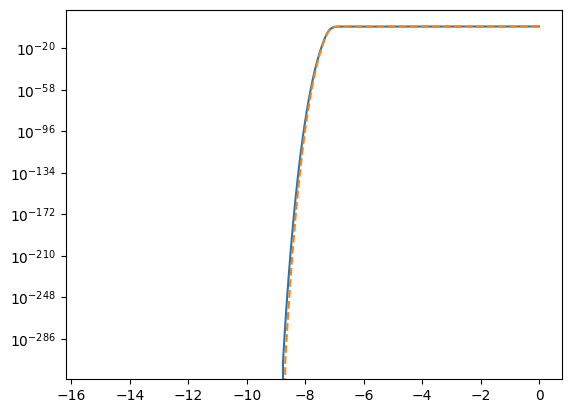

In [25]:
plt.plot(jnp.log(ath), class_kappa)
plt.plot(jnp.log(ath), diffrax_kappa, "--")
plt.yscale("log")
plt.show()

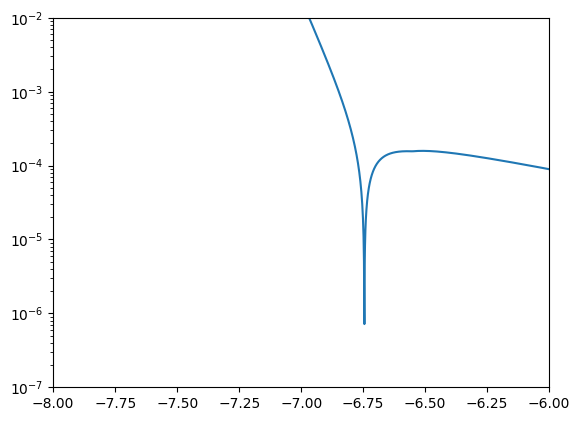

In [26]:
plt.plot(jnp.log(ath), abs(class_kappa-diffrax_kappa)/class_kappa)
#plt.plot(jnp.log(ath), before)
plt.yscale("log")
plt.xlim((-8, -6))
plt.ylim((1.e-7, 1.e-2))
plt.show()

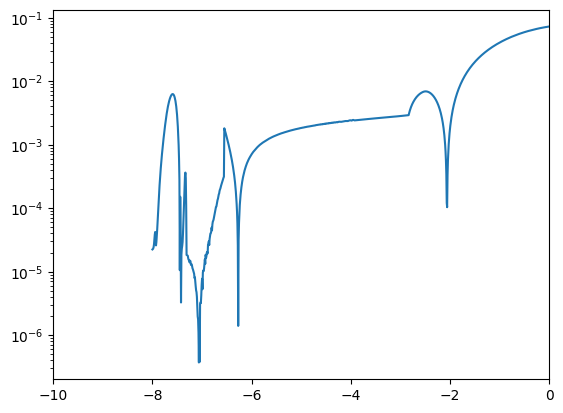

In [268]:
lna = jnp.linspace(-8, 0, 1000)
class_integrand = 1./class_aH(lna)/class_tauc(lna)
abcmb_integrand = 1./BG.aH(lna)/BG.tau_c(lna)
plt.plot(lna, abs(class_integrand-abcmb_integrand)/class_integrand)
plt.xlim((-10, 0.))
plt.yscale("log")
plt.show()

# Solving $e^{-\kappa}$

In [241]:
ath = 1/(class_rec["z"]+1)
class_tauc = lambda lna : 1./jnp.interp(lna, jnp.flip(jnp.log(class_rec['scale factor a'])), jnp.flip(class_rec["kappa' [Mpc^-1]"]))
class_xe = lambda lna : jnp.interp(lna, jnp.flip(jnp.log(class_rec['scale factor a'])), jnp.flip(class_rec["x_e"]))
abg = 1/(class_bg["z"]+1)
class_aH = lambda lna : jnp.exp(lna) * jnp.interp(lna, jnp.log(abg), class_bg['H [1/Mpc]'])

In [242]:
class_int = lambda lna, y, args: y/class_tauc(lna)/class_aH(lna)
abcmb_int = lambda lna, y, args: y/BG.tau_c(lna)/BG.aH(lna)

In [251]:
def compute_optical_depth(integrand):
    term = diffrax.ODETerm(integrand)
    stepsize_controller = diffrax.PIDController(pcoeff=0.4, icoeff=0.3, dcoeff=0, rtol=1.e-10, atol=1.e-10)
    solution = diffrax.diffeqsolve(
        term,
        solver=diffrax.Kvaerno5(),            # Higher order integrator for more accuracy
        stepsize_controller=stepsize_controller,
        t0=0.,                 # Initial x value (~0 in this case)
        t1=-9.,                  # Final x value (smallest x value)
        dt0=-1e-3,                  # Initial step size
        max_steps=8192,
        y0=1.0,                     # Initial value tau(x=0) = 0
        saveat=diffrax.SaveAt(dense=True)
    )
    return solution

In [252]:
class_sol = compute_optical_depth(class_int)
abcmb_sol = compute_optical_depth(abcmb_int)

In [253]:
class_res = class_rec['exp(-kappa)']
class_d_res = vmap(class_sol.evaluate)(jnp.log(ath))
abcmb_d_res = vmap(abcmb_sol.evaluate)(jnp.log(ath))

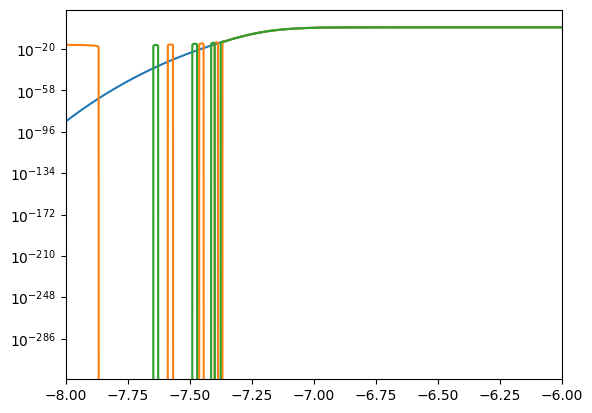

In [255]:
plt.plot(jnp.log(ath), class_res)
plt.plot(jnp.log(ath), class_d_res)
plt.plot(jnp.log(ath), abcmb_d_res)
plt.yscale("log")
plt.xlim((-8, -6))
plt.show()

In [4]:
BG = cosmology.ClassBackground()

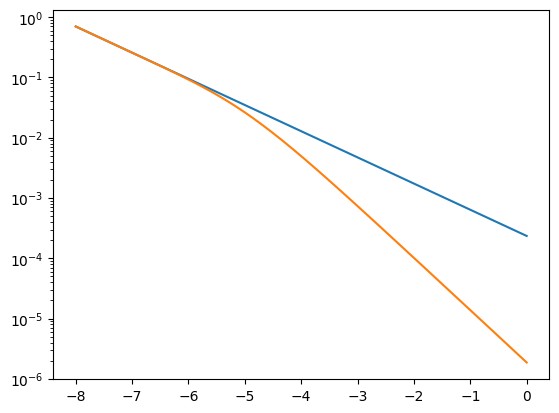

In [10]:
lna = jnp.linspace(-8, 0, 500)
plt.plot(lna, BG.TCMB(lna))
plt.plot(lna, BG.Tm(lna))
plt.yscale("log")
plt.show()

In [20]:
np.argmin((BG.TCMB(lna)-0.004)**2)

Array(322, dtype=int64)

In [28]:
np.argmin((BG.Tm(lna)/BG.TCMB(lna)-0.1)**2)

Array(340, dtype=int64)

In [30]:
lna[322]

Array(-2.83767535, dtype=float64)

In [29]:
lna[340]

Array(-2.5490982, dtype=float64)

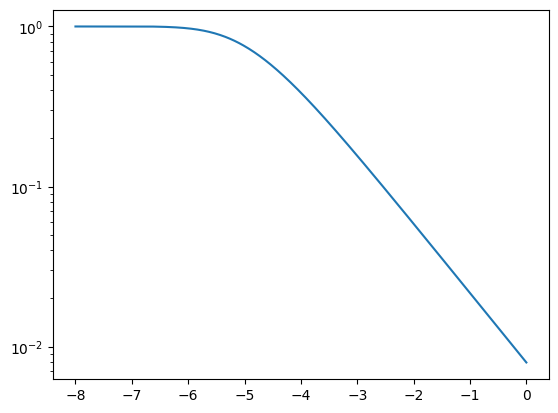

In [27]:
lna = jnp.linspace(-8, 0, 500)
plt.plot(lna, BG.Tm(lna)/BG.TCMB(lna))
plt.yscale("log")
#plt.xscale("log")
plt.show()